# Control Variate

## Table of Contents
* [1) Sampling at Expiry](#first-bullet)
    - [a) Simple Example](#firsta-bullet)
    - [b) Varying $S_0$ and $T$](#firstb-bullet)
    - [c) Varying $K$ and $T$](#firstc-bullet)
* [2) Sampling at Exercise](#second-bullet)
    - [a) Control Variate Plot to be put in Assignment](#seconda-bullet)

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os

# local
from LSM import MonteCarloOptionPricing
from figs import plot_payoffs

## 1) Sampling at Expiry <a class="anchor" id="first-bullet"></a>

### a) Simple Example <a class="anchor" id="firsta-bullet"></a>

In [8]:
# Inputs
dim = 10_000
n = 50
T = 3.
σ = 3
K = 100
r = 0.06
S0 = 96
λ = 0.4 # necessary, but only as a placeholder. Parameter does not affect results since we simulate BS!
seed = 15
use_AV = True

# create instance from class
mc_option_pricing = MonteCarloOptionPricing(r, S0, K, T, σ, λ, dim, n, seed, use_AV)

In [7]:
# simulate MC
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()
# Run LSM
mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

(92.73411940430283,
 array([0.42, 1.62, 2.04, 1.02, 0.9 , 0.48, 0.84, 1.32, 0.36, 0.48, 0.48,
        1.44, 0.84, 1.38, 0.54, 0.72, 1.98, 0.54, 0.42, 0.6 , 1.02, 1.62,
        0.42, 1.74, 0.6 , 0.48, 0.24, 0.72, 0.9 , 0.84, 0.48, 0.42, 1.02,
        0.54, 0.42, 0.54, 0.96, 0.84, 0.78, 1.38, 0.36, 0.54, 0.36, 1.08,
        1.02, 0.54, 2.22, 0.6 , 0.78, 0.9 , 0.9 , 2.46, 0.66, 0.42, 0.78,
        1.02, 0.42, 2.76, 1.26, 0.72, 1.56, 0.24, 1.32, 0.42, 1.92, 0.42,
        1.14, 1.38, 0.84, 1.32, 0.36, 0.36, 1.74, 0.18, 1.26, 0.78, 0.54,
        0.48, 0.84, 0.66, 2.22, 0.66, 0.42, 0.96, 0.48, 2.28, 0.48, 0.66,
        0.96, 1.14, 1.8 , 0.72, 0.78, 0.42, 2.4 , 3.  , 2.34, 0.48, 1.68,
        2.4 , 0.6 , 0.78, 2.04, 1.56, 0.66, 0.42, 2.22, 2.22, 0.84, 2.64,
        0.72, 0.54, 0.36, 1.38, 0.12, 0.3 , 1.98, 0.24, 1.26, 2.16, 0.48,
        0.3 , 0.18, 0.42, 1.38, 0.66, 1.56, 0.96, 0.54, 0.96, 1.14, 1.2 ,
        0.3 , 0.6 , 0.3 , 0.54, 2.04, 0.3 , 0.48, 2.88, 0.78, 1.56, 1.98,
        0.42, 1.26

In [29]:
mc_option_pricing.payoffs.mean()

97.83533484289406

In [4]:
# Access and print the payoffs
American_payoffs = mc_option_pricing.payoffs
print("Individual Payoffs:", American_payoffs)

Control_payoffs = np.exp(-r * T) * np.maximum(K - mc_option_pricing.S[:, -1], 0) # European put at expiry
print("Control payoffs:", Control_payoffs)

Individual Payoffs: [98.63945451 99.37033372 99.36559469 ... 99.63676533 99.11596911
 99.17876821]
Control payoffs: [83.52702074 83.52454746 83.52685133 ... 83.38493825 82.10419513
 83.52689916]


Now, the prices (averaging over the previously payoffs)

In [5]:
# Estimate prices by crude Monte Carlo
American_price_est = np.mean(American_payoffs)
Control_price_est = np.mean(Control_payoffs)
print(American_price_est)
print(Control_price_est)
assert len(American_payoffs) == dim and len(Control_payoffs) == dim, "Lengths of American_payoffs and Control_payoffs are not equal to no. of simulations"

97.83533484289406
82.57779672150951


Auxiliary functions (note, necessary to run prior to Section 1.b and 1.c)

In [6]:
def calculate_theta(american_payoffs, control_payoffs):
    return -np.cov(american_payoffs, control_payoffs)[0, 1] / np.var(control_payoffs) # remember to use off-diagonal
 
def calculate_correlation(american_payoffs, control_payoffs):
    return -np.corrcoef(american_payoffs, control_payoffs)[0, 1]

Calculate statistics

In [7]:
# Compute expected mean of European control variate (i.e., BS)
control_mean = mc_option_pricing.BS_option_value('put')

# Calculates Y_i's
θ = calculate_theta(American_payoffs, Control_payoffs)
Y = American_payoffs + θ*(Control_payoffs - control_mean)
ρ = calculate_correlation(American_payoffs, Control_payoffs)
squared_corr = ρ**2
price_estimate = np.mean(Y)
variance_ratio = np.var(American_payoffs) / np.var(Y)
reduction_factor = (1-squared_corr)**(-1)

# Print results
print(f'\u03C1: {ρ:.6f}')
print(f'\u03C1^2: {squared_corr:.6f}')
print(f'Control Variate Price Estimate: {price_estimate:.6f}')
print(f'Variance Ratio of Payoffs (American/Control Variate): {variance_ratio:.6f}')
print(f'Reduction Factor (1 - \u03C1^2)^(-1): {reduction_factor:.6f}')

ρ: -0.818914
ρ^2: 0.670620
Control Variate Price Estimate: 97.954481
Variance Ratio of Payoffs (American/Control Variate): 3.036007
Reduction Factor (1 - ρ^2)^(-1): 3.036007


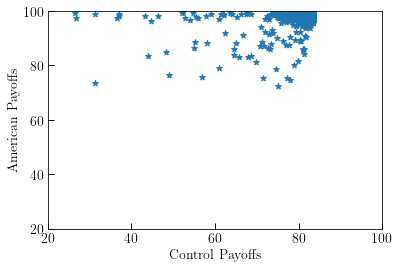

In [8]:
plot_payoffs(American_payoffs, Control_payoffs, x_limits=(20, 100), y_limits=(20, 100))

### Varying $S_0$ and $T$ <a class="anchor" id="firstb-bullet"></a>

Running simulation for S0=90, T=2
ρ: -0.736653
ρ^2: 0.542657
Control Variate Price Estimate: 21.882105
Variance Ratio of Payoffs (American/Control Variate): 2.186543
Reduction Factor (1 - ρ^2)^(-1): 2.186543


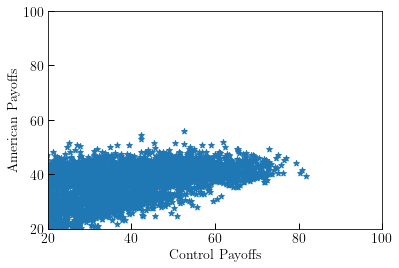

Running simulation for S0=90, T=3
ρ: -0.726469
ρ^2: 0.527757
Control Variate Price Estimate: 25.014856
Variance Ratio of Payoffs (American/Control Variate): 2.117556
Reduction Factor (1 - ρ^2)^(-1): 2.117556


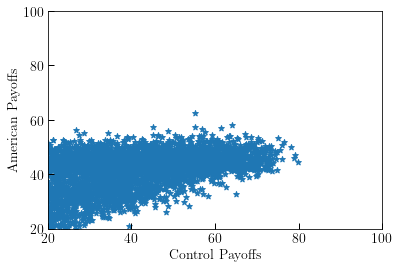

Running simulation for S0=90, T=4
ρ: -0.718161
ρ^2: 0.515756
Control Variate Price Estimate: 27.398841
Variance Ratio of Payoffs (American/Control Variate): 2.065074
Reduction Factor (1 - ρ^2)^(-1): 2.065074


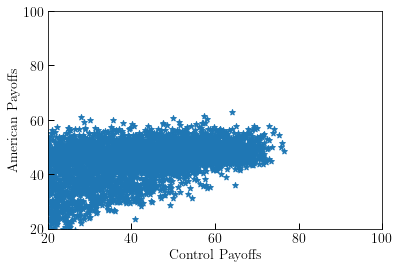

Running simulation for S0=100, T=2
ρ: -0.768659
ρ^2: 0.590837
Control Variate Price Estimate: 17.784784
Variance Ratio of Payoffs (American/Control Variate): 2.444015
Reduction Factor (1 - ρ^2)^(-1): 2.444015


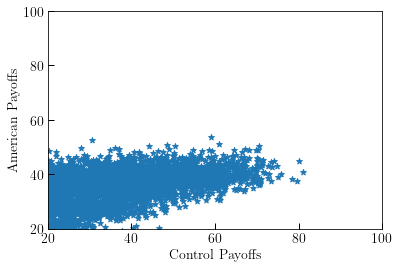

Running simulation for S0=100, T=3
ρ: -0.759846
ρ^2: 0.577366
Control Variate Price Estimate: 21.068174
Variance Ratio of Payoffs (American/Control Variate): 2.366111
Reduction Factor (1 - ρ^2)^(-1): 2.366111


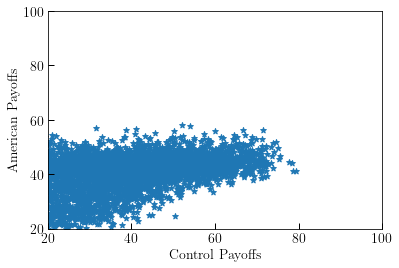

Running simulation for S0=100, T=4
ρ: -0.734469
ρ^2: 0.539445
Control Variate Price Estimate: 23.583348
Variance Ratio of Payoffs (American/Control Variate): 2.171295
Reduction Factor (1 - ρ^2)^(-1): 2.171295


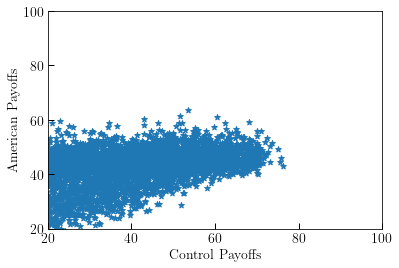

Running simulation for S0=110, T=2
ρ: -0.798531
ρ^2: 0.637651
Control Variate Price Estimate: 14.567737
Variance Ratio of Payoffs (American/Control Variate): 2.759771
Reduction Factor (1 - ρ^2)^(-1): 2.759771


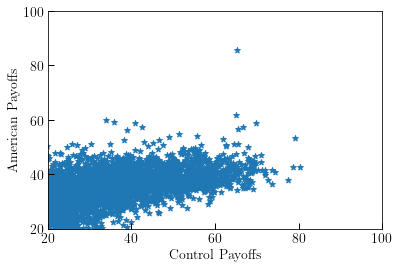

Running simulation for S0=110, T=3
ρ: -0.782312
ρ^2: 0.612011
Control Variate Price Estimate: 17.902755
Variance Ratio of Payoffs (American/Control Variate): 2.577395
Reduction Factor (1 - ρ^2)^(-1): 2.577395


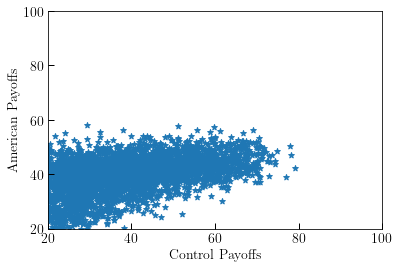

Running simulation for S0=110, T=4
ρ: -0.761401
ρ^2: 0.579731
Control Variate Price Estimate: 20.638642
Variance Ratio of Payoffs (American/Control Variate): 2.379427
Reduction Factor (1 - ρ^2)^(-1): 2.379427


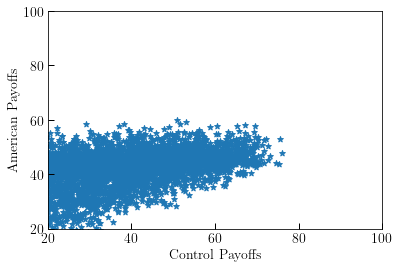

<Figure size 432x288 with 0 Axes>

In [9]:
# Define ranges for K, σ, and T
S0_values = [90, 100, 110]
T_values = [2, 3, 4]

# List to store squared correlations and parameter labels
squared_correlations = []
parameter_labels = []

# Loop over combinations of K and T
for S0 in S0_values:
        for T in T_values:
            print(f"Running simulation for S0={S0}, T={T}")

            # Initialize the Monte Carlo pricer
            mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=S0, K=100, T=T, σ=0.4, λ=0.4, dim=10_000, n=50, seed=15, use_AV=True)

            # Simulate GBM and apply the LSM algorithm
            simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()
            mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

            # Access and print the payoffs
            American_payoffs = mc_option_pricing.payoffs
            Control_payoffs = np.exp(-r * T) * np.maximum(K - mc_option_pricing.S[:, -1], 0)

            # Estimate prices by crude Monte Carlo
            American_price_est = np.mean(American_payoffs)
            Control_price_est = np.mean(Control_payoffs)
            
            # Compute expected mean of European control variate (i.e., BS)
            control_mean = mc_option_pricing.BS_option_value('put')
            
            # Calculates Y_i's
            θ = calculate_theta(American_payoffs, Control_payoffs)
            Y = American_payoffs + θ*(Control_payoffs - control_mean)
            ρ = calculate_correlation(American_payoffs, Control_payoffs)
            squared_corr = ρ**2
            price_estimate = np.mean(Y)
            variance_ratio = np.var(American_payoffs) / np.var(Y)
            reduction_factor = (1-squared_corr)**(-1)

            # Print results
            print(f'\u03C1: {ρ:.6f}')
            print(f'\u03C1^2: {squared_corr:.6f}')
            print(f'Control Variate Price Estimate: {price_estimate:.6f}')
            print(f'Variance Ratio of Payoffs (American/Control Variate): {variance_ratio:.6f}')
            print(f"Reduction Factor (1 - \u03C1^2)^(-1): {reduction_factor:.6f}")
           
            # Plot payoffs for correlation
            plot_payoffs(American_payoffs, Control_payoffs, x_limits=(20, 100), y_limits=(20, 100))

            # Clear the plot for the next iteration
            plt.clf()
            
            # Store the squared correlation and parameter label
            parameter_label = f"{S0}/{T}"
            squared_correlations.append(squared_corr)
            parameter_labels.append(parameter_label)

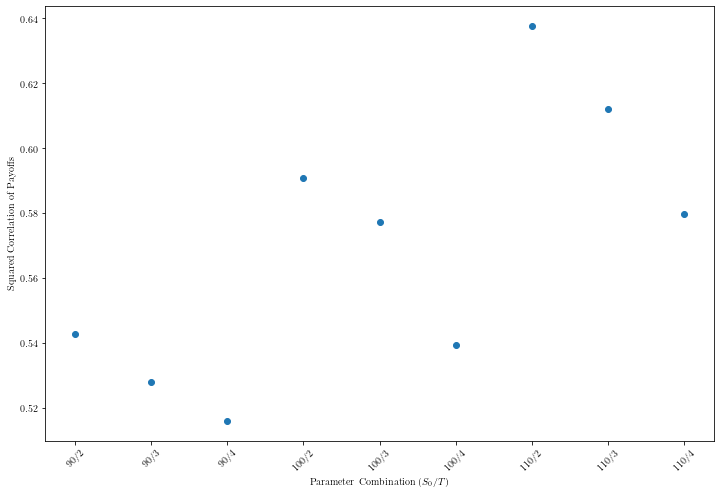

In [10]:
# Plot squared correlations against parameter combinations
plt.figure(figsize=(12, 8))
plt.plot(parameter_labels, squared_correlations, 'o', label='Squared Correlation')
plt.xlabel(r'Parameter Combination ($S_0$/$T$)')
plt.ylabel('Squared Correlation of Payoffs')
#plt.title('Squared Correlation of Payoffs for Different Option Parameters')
plt.xticks(rotation=45)
#plt.legend()
plt.show()

### Varying $K$ and $T$ <a class="anchor" id="firstc-bullet"></a>

Running simulation for K=90, T=2
ρ: -0.800885
ρ^2: 0.641416
Control Variate Price Estimate: 12.844581
Variance Ratio of Payoffs (American/Control Variate): 2.788747
Reduction Factor (1 - ρ^2)^(-1): 2.788747


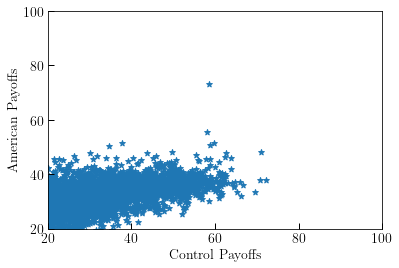

Running simulation for K=90, T=3
ρ: -0.782563
ρ^2: 0.612406
Control Variate Price Estimate: 15.861583
Variance Ratio of Payoffs (American/Control Variate): 2.580016
Reduction Factor (1 - ρ^2)^(-1): 2.580016


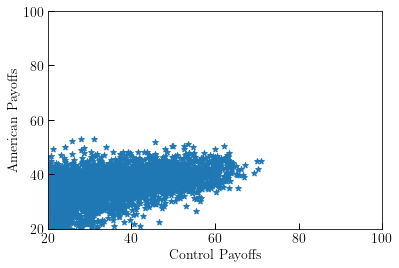

Running simulation for K=90, T=4
ρ: -0.767220
ρ^2: 0.588626
Control Variate Price Estimate: 18.345061
Variance Ratio of Payoffs (American/Control Variate): 2.430879
Reduction Factor (1 - ρ^2)^(-1): 2.430879


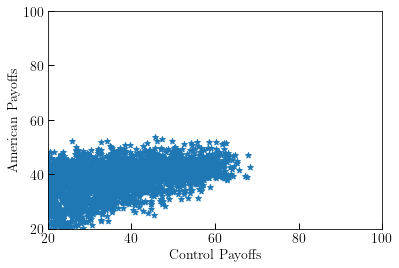

Running simulation for K=100, T=2
ρ: -0.768659
ρ^2: 0.590837
Control Variate Price Estimate: 17.784784
Variance Ratio of Payoffs (American/Control Variate): 2.444015
Reduction Factor (1 - ρ^2)^(-1): 2.444015


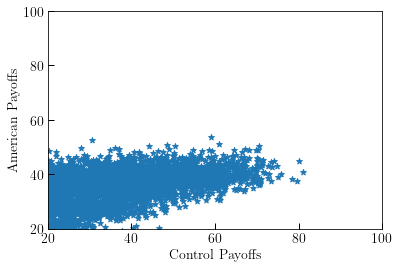

Running simulation for K=100, T=3
ρ: -0.759846
ρ^2: 0.577366
Control Variate Price Estimate: 21.068174
Variance Ratio of Payoffs (American/Control Variate): 2.366111
Reduction Factor (1 - ρ^2)^(-1): 2.366111


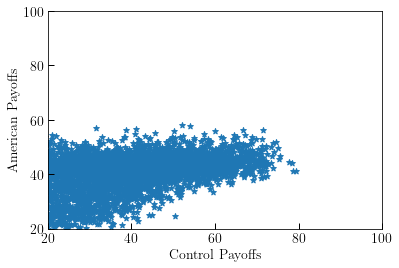

Running simulation for K=100, T=4
ρ: -0.734469
ρ^2: 0.539445
Control Variate Price Estimate: 23.583348
Variance Ratio of Payoffs (American/Control Variate): 2.171295
Reduction Factor (1 - ρ^2)^(-1): 2.171295


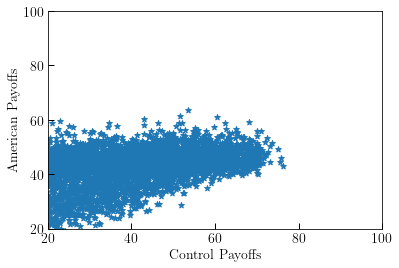

Running simulation for K=110, T=2
ρ: -0.741083
ρ^2: 0.549205
Control Variate Price Estimate: 23.607876
Variance Ratio of Payoffs (American/Control Variate): 2.218301
Reduction Factor (1 - ρ^2)^(-1): 2.218301


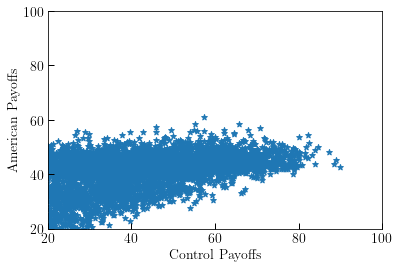

Running simulation for K=110, T=3
ρ: -0.727537
ρ^2: 0.529310
Control Variate Price Estimate: 27.044154
Variance Ratio of Payoffs (American/Control Variate): 2.124541
Reduction Factor (1 - ρ^2)^(-1): 2.124541


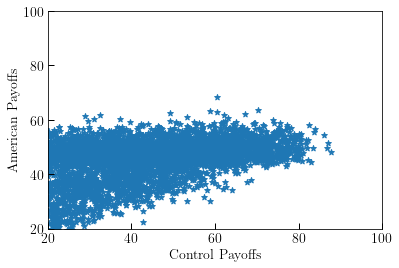

Running simulation for K=110, T=4
ρ: -0.720533
ρ^2: 0.519168
Control Variate Price Estimate: 29.749479
Variance Ratio of Payoffs (American/Control Variate): 2.079729
Reduction Factor (1 - ρ^2)^(-1): 2.079729


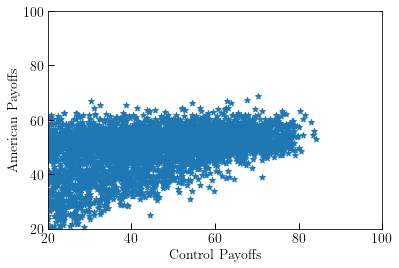

<Figure size 432x288 with 0 Axes>

In [11]:
# Define ranges for K, σ, and T
K_values = [90, 100, 110]
T_values = [2, 3, 4]

# List to store squared correlations and parameter labels
squared_correlations = []
parameter_labels = []

# Loop over combinations of K and T
for K in K_values:
        for T in T_values:
            print(f"Running simulation for K={K}, T={T}")

            # Initialize the Monte Carlo pricer
            mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=100, K=K, T=T, σ=0.4, λ=0.4, dim=10_000, n=50, seed=15, use_AV=True)

            # Simulate GBM and apply the LSM algorithm
            simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()
            mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

            # Access and print the payoffs
            American_payoffs = mc_option_pricing.payoffs
            Control_payoffs = np.exp(-r * T) * np.maximum(K - mc_option_pricing.S[:, -1], 0)

            # Estimate prices by crude Monte Carlo
            American_price_est = np.mean(American_payoffs)
            Control_price_est = np.mean(Control_payoffs)
            
            # Compute expected mean of European control variate (i.e., BS)
            control_mean = mc_option_pricing.BS_option_value('put')
            
            # Calculates Y_i's
            θ = calculate_theta(American_payoffs, Control_payoffs)
            Y = American_payoffs + θ*(Control_payoffs - control_mean)
            ρ = calculate_correlation(American_payoffs, Control_payoffs)
            squared_corr = ρ**2
            price_estimate = np.mean(Y)
            variance_ratio = np.var(American_payoffs) / np.var(Y)
            reduction_factor = (1-squared_corr)**(-1)

            # Print results
            print(f'\u03C1: {ρ:.6f}')
            print(f'\u03C1^2: {squared_corr:.6f}')
            print(f'Control Variate Price Estimate: {price_estimate:.6f}')
            print(f'Variance Ratio of Payoffs (American/Control Variate): {variance_ratio:.6f}')
            print(f"Reduction Factor (1 - \u03C1^2)^(-1): {reduction_factor:.6f}")
           
            # Plot payoffs for correlation
            plot_payoffs(American_payoffs, Control_payoffs, x_limits=(20, 100), y_limits=(20, 100))

            # Clear the plot for the next iteration
            plt.clf()
            
            # Store the squared correlation and parameter label
            parameter_label = f"{K}/{T}"
            squared_correlations.append(squared_corr)
            parameter_labels.append(parameter_label)

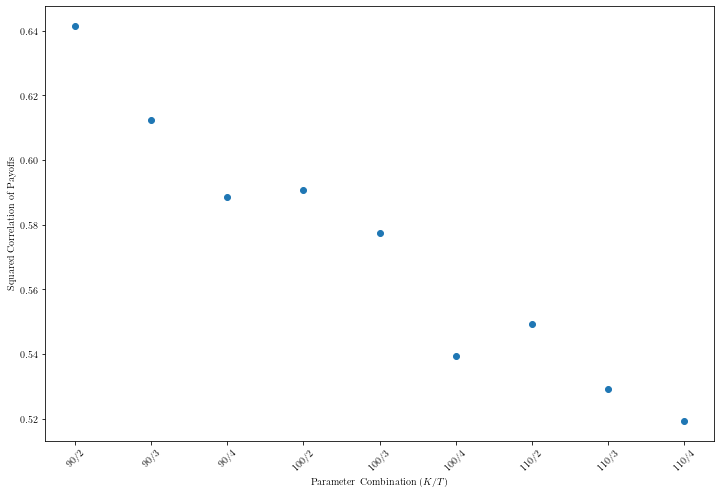

In [12]:
# Plot squared correlations against parameter combinations
plt.figure(figsize=(12, 8))
plt.plot(parameter_labels, squared_correlations, 'o', label='Squared Correlation')
plt.xlabel(r'Parameter Combination ($K$/$T$)')
plt.ylabel('Squared Correlation of Payoffs')
#plt.title('Squared Correlation of Payoffs for Different Option Parameters')
plt.xticks(rotation=45)
#plt.legend()
plt.show()

## 2) Sampling at Exercise <a class="anchor" id="second-bullet"></a>

In [13]:
# Create instance from class with the following inputs
mc_option_pricing_ex = MonteCarloOptionPricing(r=0.06, S0=110, K=100, T=3., σ=0.4, λ=0.4, dim=10_000, n=50, seed=15, use_AV=True)

# simulate MC
simulated_paths = mc_option_pricing_ex.GeometricBrownianMotion_vec()

# Run LSM
lsm_output = mc_option_pricing_ex.american_option_LSM(poly_degree=3, otype='put')

#exercise_times
American_exercise_times = lsm_output[1]

# Access and print the payoffs
American_payoffs_ex = mc_option_pricing_ex.payoffs

# Initialize variables for Control payoffs
Control_payoffs_ex = np.zeros(mc_option_pricing_ex.dim)

In [14]:
mc_option_pricing_ex.S.shape

(10000, 50)

Auxiliary functions

In [15]:
def calculate_theta(american_payoffs, control_payoffs):
    return -np.cov(american_payoffs, control_payoffs)[0, 1] / np.var(control_payoffs) # remember to use off-diagonal
 
def calculate_correlation(american_payoffs, control_payoffs):
    return -np.corrcoef(american_payoffs, control_payoffs)[0, 1]

def get_stock_price_at_exercise(S, American_exercise_times, n, r, T, K, default_value=500):
    """
    Get the stock price at the specific exercise time for each path.

    Parameters:
    S (np.array): 2D array of stock prices for different paths and timesteps.
    American_exercise_times (np.array): Array of exercise times for each path.
    n (int): The number of time steps.
    r (float): Risk-free interest rate.
    T (float): Time to maturity.
    K (float): Strike price of the option.
    default_value (float): Default stock price if the option was never exercised.

    Returns:
    np.array: Array of payoffs at the specific exercise time for each path.
    """
    stock_prices_at_exercise = []  # List to store stock prices at exercise times
    Control_payoffs_ex = np.zeros(len(American_exercise_times))  # Initialize array for control payoffs

    for i, exercise_time in enumerate(American_exercise_times):
        if exercise_time == T:  # Option was never exercised
            stock_price = default_value
        else:
            column_index = int(exercise_time / (T / n))  # Convert time to column index
            stock_price = S[i, column_index]

        stock_prices_at_exercise.append(stock_price)
        Control_payoffs_ex[i] = np.exp(-r * exercise_time) * np.maximum(K - stock_price, 0)

    return Control_payoffs_ex

In [16]:
Control_payoffs_ex = get_stock_price_at_exercise(mc_option_pricing_ex.S, American_exercise_times, mc_option_pricing_ex.n, mc_option_pricing_ex.r, mc_option_pricing_ex.T, mc_option_pricing_ex.K)
#print(Control_payoffs_ex.shape)

In [17]:
squared_corr_ex = (np.corrcoef(American_payoffs_ex, Control_payoffs_ex)[0, 1])**2
print("squared corr.:", '{:.18f}'.format(squared_corr_ex))

squared corr.: 0.986408850740464027


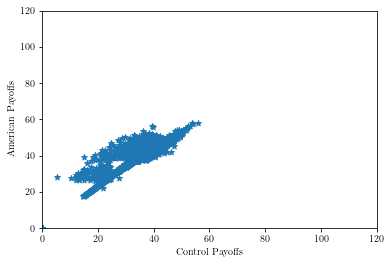

In [18]:
plt.scatter(Control_payoffs_ex, American_payoffs_ex, marker='*', label='Payoffs')
plt.xlabel('Control Payoffs')
plt.ylabel('American Payoffs')

# Set axis limits
x_min, x_max = 0, 120
y_min, y_max = 0, 120 
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max);

In [19]:
# Compute expected mean of European control variate (i.e., BS)
control_mean_ex = mc_option_pricing_ex.BS_option_value('put')

# Calculates Y_i's
θ_ex = calculate_theta(American_payoffs_ex, Control_payoffs_ex)
Y_ex = American_payoffs_ex + θ_ex*(Control_payoffs_ex - control_mean_ex)
ρ_ex = calculate_correlation(American_payoffs_ex, Control_payoffs_ex)
squared_corr_ex = ρ_ex**2
price_estimate_ex = np.mean(Y_ex)
variance_ratio_ex = np.var(American_payoffs_ex) / np.var(Y_ex)
reduction_factor_ex = (1-squared_corr_ex)**(-1)

# Print results
print(f'\u03C1: {ρ_ex:.6f}')
print(f'\u03C1^2: {squared_corr_ex:.6f}')
print(f'Control Variate Price Estimate: {price_estimate_ex:.6f}')
print(f'Variance Ratio of Payoffs (American/Control Variate): {variance_ratio_ex:.6f}')
print(f"Reduction Factor (1 - \u03C1^2)^(-1): {reduction_factor_ex:.6f}")

ρ: -0.993181
ρ^2: 0.986409
Control Variate Price Estimate: 16.958368
Variance Ratio of Payoffs (American/Control Variate): 73.577242
Reduction Factor (1 - ρ^2)^(-1): 73.577295


## Control Variate Plot to be put in Assignment <a class="anchor" id="seconda-bullet"></a>

After some bruteforcing, we can plot it...

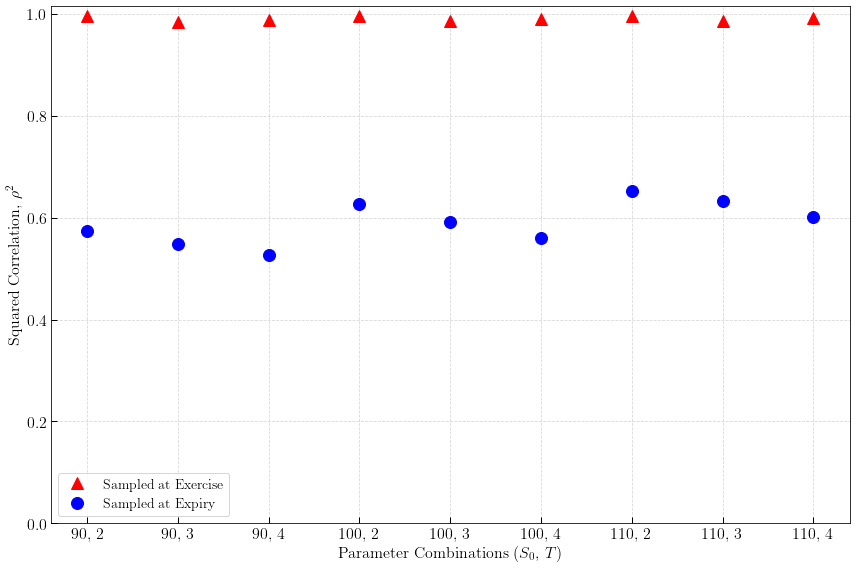

In [20]:
# data
parameter_combinations = ["90, 2", "90, 3", "90, 4",
                          "100, 2", "100, 3", "100, 4",
                          "110, 2", "110, 3", "110, 4"]

sampled_at_exercise = [0.996881, 0.984, 0.989,
                       0.9965, 0.986, 0.991,
                       0.997, 0.986, 0.992]

sampled_at_expiry = [0.573, 0.548, 0.526,
                     0.626, 0.591, 0.560,
                     0.652, 0.633, 0.601]

# Create figure and axis
plt.figure(figsize=(12, 8))
plt.plot(parameter_combinations, sampled_at_exercise, 'r^', label='Sampled at Exercise', markersize=12)
plt.plot(parameter_combinations, sampled_at_expiry, 'bo', label='Sampled at Expiry', markersize=12)

# Set the y-axis limit
plt.ylim([0, 1.015])

# labels and title
plt.xlabel('Parameter Combinations ($S_0$, $T$)', fontsize=16)
plt.ylabel('Squared Correlation, $\\rho^2$', fontsize=16)
#plt.title('Comparison of Sampled Correlations at Exercise and Expiry', fontsize=18)

# grid
plt.grid(True, linestyle='--', alpha=0.5)

plt.tick_params(axis='both', direction='in', length=6, width=1, colors='black', grid_alpha=0.5, labelsize=16)

# customized legend
plt.legend(loc='lower left', fontsize=14, frameon=True)

# Save the figure to a PDF in the working folder
plt.tight_layout()

# Check for directory and save the figure
if not os.path.exists("../Results/plots"):
    os.makedirs("../Results/plots")

plt.savefig(f"../Results/plots/ControlVariate.pdf", bbox_inches='tight')

# Show the plot
plt.show()